# Residual saturation $s_r$

In [1]:
import numpy as np
from lucifex.solver import OptionsPETSc
from lucifex.fdm import AB, CN
from lucifex.sim import run, Simulation
from lucifex.viz import plot_colormap, plot_line
from crocodil.dns.system_a import dns_system_a, SYSTEM_A_REFERENCE, critical_sr

STORE = 1
NX = 80
NY = 80

def create_simulation(
    sr: float,
):
    physical = dict(SYSTEM_A_REFERENCE)
    physical.update(sr=sr)
    return dns_system_a(
        store_delta=STORE, 
    )(
        Nx=NX,
        Ny=NY,
        scaling='advective',
        **physical,
        D_adv=AB(1)@CN,
        D_diff=AB(1)@CN,
        dt_max=0.1,
        cfl_courant=0.5,
        c_stabilization=None,
        c_limits=None,
        c_petsc=OptionsPETSc('gmres', 'ilu'),
        flow_petsc=(OptionsPETSc('cg', 'hypre'), None),
        diagnostic=True,
    )


H0 = SYSTEM_A_REFERENCE['h0']
CR = SYSTEM_A_REFERENCE['cr']
EPSILON = SYSTEM_A_REFERENCE['epsilon']
sr_crit = critical_sr(H0, CR, EPSILON)
print(f'sr_crit = {sr_crit}')

sr_opts = (0.01, 0.5, sr_crit, 0.2)
simulations: dict[float, Simulation] = {}

for sr in sr_opts:
    simulations[sr] = create_simulation(sr)

n_stop = 100
t_stop = 20.0
dt_init = 1e-6
n_init = 10
for sr in sr_opts:
    sim = simulations[sr]
    run(sim, n_stop, t_stop, dt_init=dt_init, n_init=n_init)

sr_crit = 0.10000000000000002


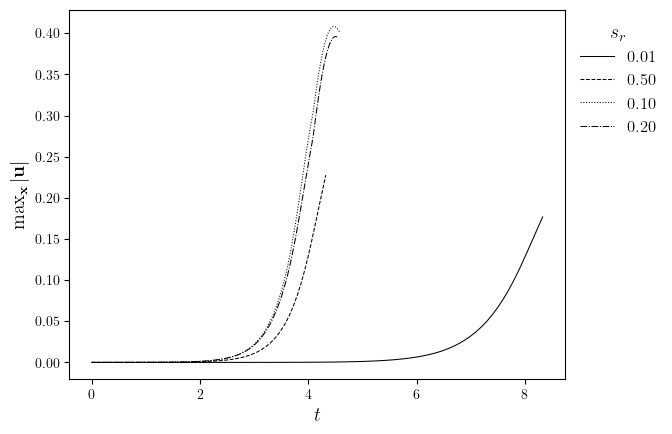

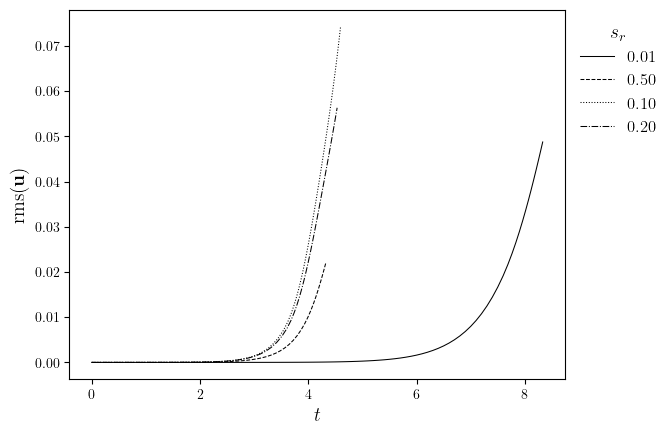

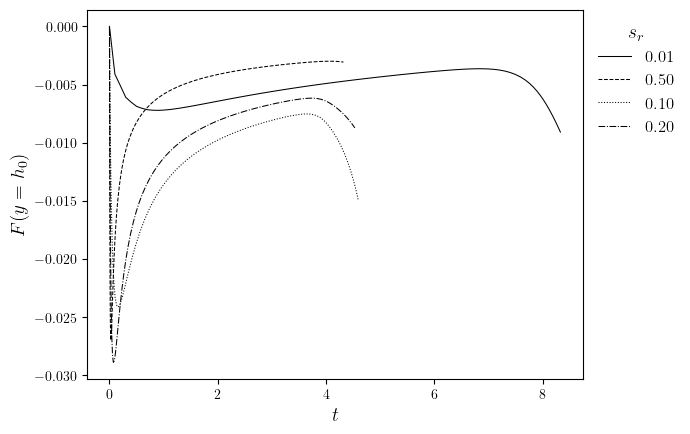

In [2]:
uMax_lines, uRMS_lines, f_lines = [], [], []
legend_title = f'$s_r$'

for sr in sr_opts:
    sim = simulations[sr]
    f = sim['f']
    f, fPlus, fMinus = f.split()
    f_lines.append((f.time_series, [np.sum(i) for i in f.value_series]))
    uMinMax = sim['uMinMax']
    uMax = uMinMax.sub(1)
    uMax_lines.append((uMax.time_series, uMax.value_series))
    uRMS = sim['uRMS']
    uRMS_lines.append((uRMS.time_series, uRMS.value_series))

legend_labels = [f'{sr:.2f}' for sr in sr_opts]
fig, ax = plot_line(
    uMax_lines,
    cyc='black',
    x_label='$t$',
    y_label='$\max_{\mathbf{x}}|\mathbf{u}|$',
    legend_labels=legend_labels,
    legend_title=legend_title,
)
fig, ax = plot_line(
    uRMS_lines,
    x_label='$t$',
    y_label='$\mathrm{rms}(\mathbf{u})$',
    legend_labels=legend_labels,
    legend_title=legend_title,
)
fig, ax = plot_line(
    f_lines,
    cyc='black',
    x_label='$t$',
    y_label='$F(y=h_0)$',
    legend_labels=legend_labels,
    legend_title=legend_title,
)

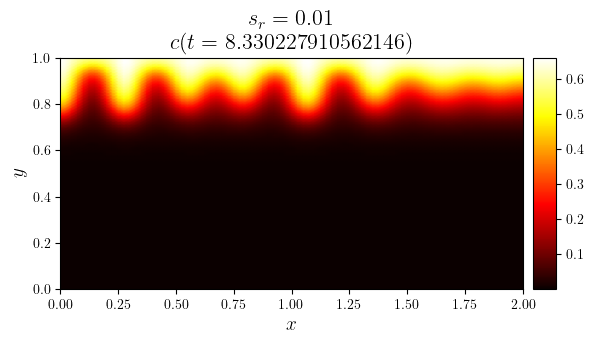

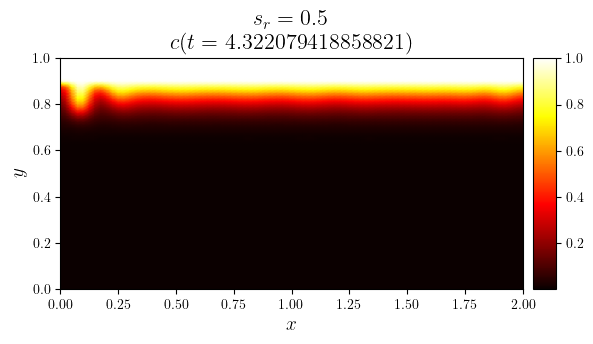

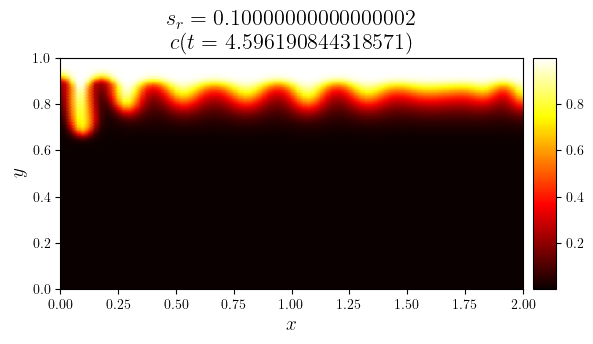

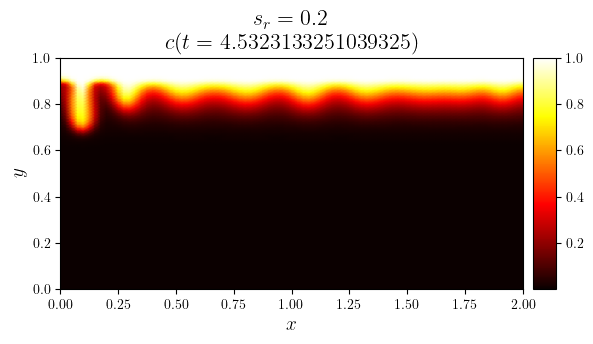

In [3]:
time_indices = (-1, )
for sr in sr_opts:
    sim = simulations[sr]
    c = sim['c']
    for i in time_indices:
        fig, ax = plot_colormap(
            c.series[i], 
            title=f'$s_r={sr}$\n$c(t={c.time_series[i]})$',
        )